In [1]:
import wget
import healpy as hp
import numpy as np
import pylab as pl 
from pathlib import Path
import scipy
from scipy.optimize import curve_fit

from astropy import units as u, constants as const
fstring="COM_CompMap_freefree-commander_0256_R2.00.fits"
try :
    print(f"reading {fstring} ")
    maps=  hp.read_map(filename=f"../lwa_data/{fstring}" ,field= ['EM_ML', 'TEMP_ML']  )  
except FileNotFoundError: 
    filename = wget.download( f"http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_freefree-commander_0256_R2.00.fits" , out ="../lwa_data")
    maps=  hp.read_map(f"../lwa_data/{fstring}" ,field= ['EM_ML', 'TEMP_ML']  )
 


fstring = "EM_mean_std.fits"
try :
    print(f"reading {fstring} ")
    hust=  hp.read_map(filename=f"../lwa_data/{fstring}"   )  
except FileNotFoundError: 
    filename = wget.download( f"https://zenodo.org/records/10523170/files/EM_mean_std.fits" , out ="../lwa_data")
    hust =  hp.read_map(f"../lwa_data/{fstring}"    )
hust *= u.cm**-6 *u.pc

reading COM_CompMap_freefree-commander_0256_R2.00.fits 
reading EM_mean_std.fits 


In [2]:
planck_em = maps[0]* u.cm**-6 *u.pc
planck_te = maps[1]*u.K 

print(planck_em , planck_te )

[1.87581873e+00 1.50219643e+00 2.06140414e-01 ... 1.00000056e-04
 1.00000092e-04 1.00000041e-04] pc / cm6 [7000.0405 7000.0415 7000.0386 ... 7000.0156 7000.025  7000.0293] K


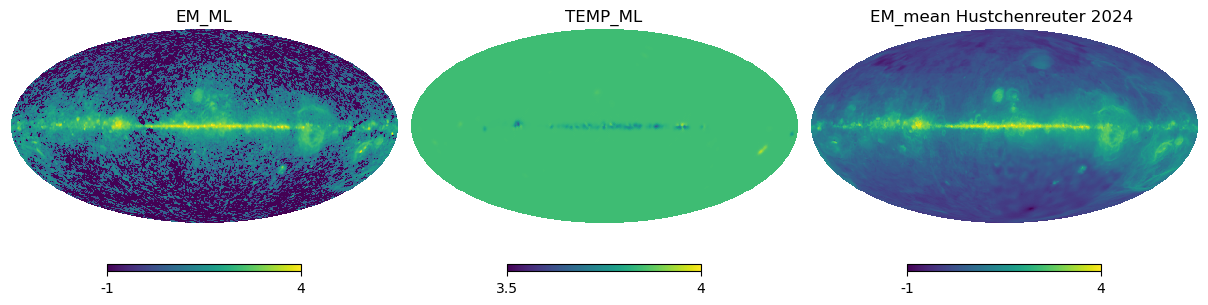

In [3]:
pl.figure(figsize=(12, 8))

hp.mollview(pl.log10(planck_em.value ),max=4, min=-1,  sub=131, title="EM_ML" ) ; 
hp.mollview( pl.log10(planck_te .value ), sub=132, title="TEMP_ML"   , min=3.5,max=4  ) ; 
hp.mollview( pl.log10(hust.value  ), sub=133, title="EM_mean Hustchenreuter 2024 "   ,max=4, min=-1 ) ; 

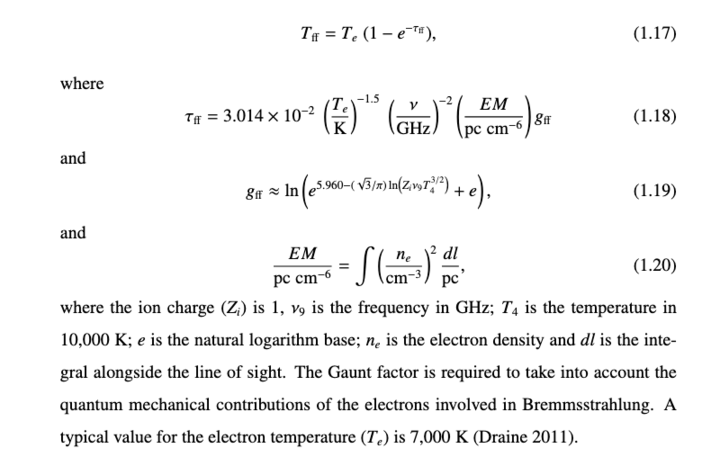

In [4]:
Tff = lambda Te , nu,EM  : Te * (1.0 - np.exp(-tauff(Te,nu, EM ))) 
tauff = lambda Te,nu , EM : 3.014e-2  *   (Te.value )**1.5 * (nu.value )**-2 *EM.value   *gff (Te,nu) 
Zi =1 
gff =lambda Te ,nu :  np.log (np.exp(1.0) +np.exp (5.960 -np.sqrt(3)/np.pi *np.log (Zi *nu.to(u.GHz).value *(Te/(1e4*u.K)  )**1.5  )) )  

In [5]:
fwhms = {35: 4.7*u.deg, 
         38:4.3 *u.deg , 
        40:4.1*u.deg,
        45:3.6*u.deg,
        50:3.3*u.deg,
        60:2.7*u.deg,
        70:2.3*u.deg,
        74:2.2*u.deg,
        80:2.0*u.deg,
       408 :56*u.arcmin, 
         820:1.2*u.deg, 
       1400: 14.4*u.arcmin, #https://lambda.gsfc.nasa.gov/product/foreground/fg_chipass_info.html
       2326: 20 *u.arcmin, 
         11000:1*u.deg, 
       23000: 0.88*u.deg #https://lambda.gsfc.nasa.gov/product/wmap/dr5/
        }

In [6]:
freqs= np.array(list(fwhms.keys())) * u.MHz 


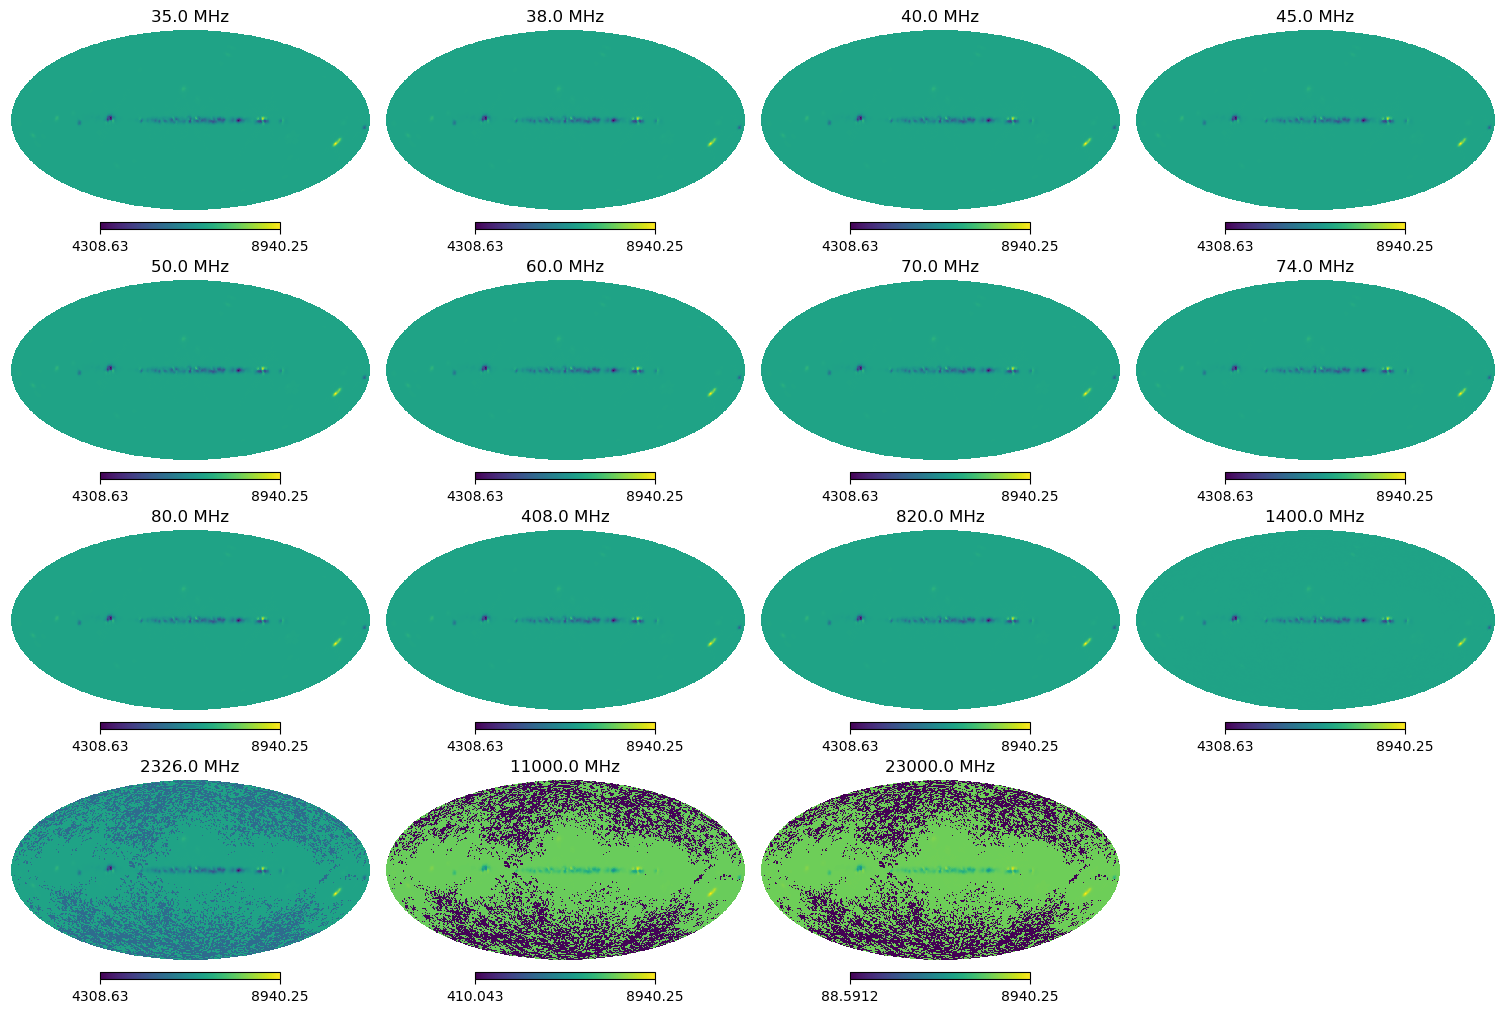

In [9]:
pl.figure(figsize=(15,10)) 
j=0
for fr  in freqs :
     
    hp.mollview(  Tff( planck_te, fr .to(u.GHz ), planck_em)  ,  title=f'{fr}'  , sub=(4,4,1+j) , notext=True    )
    
    j+=1

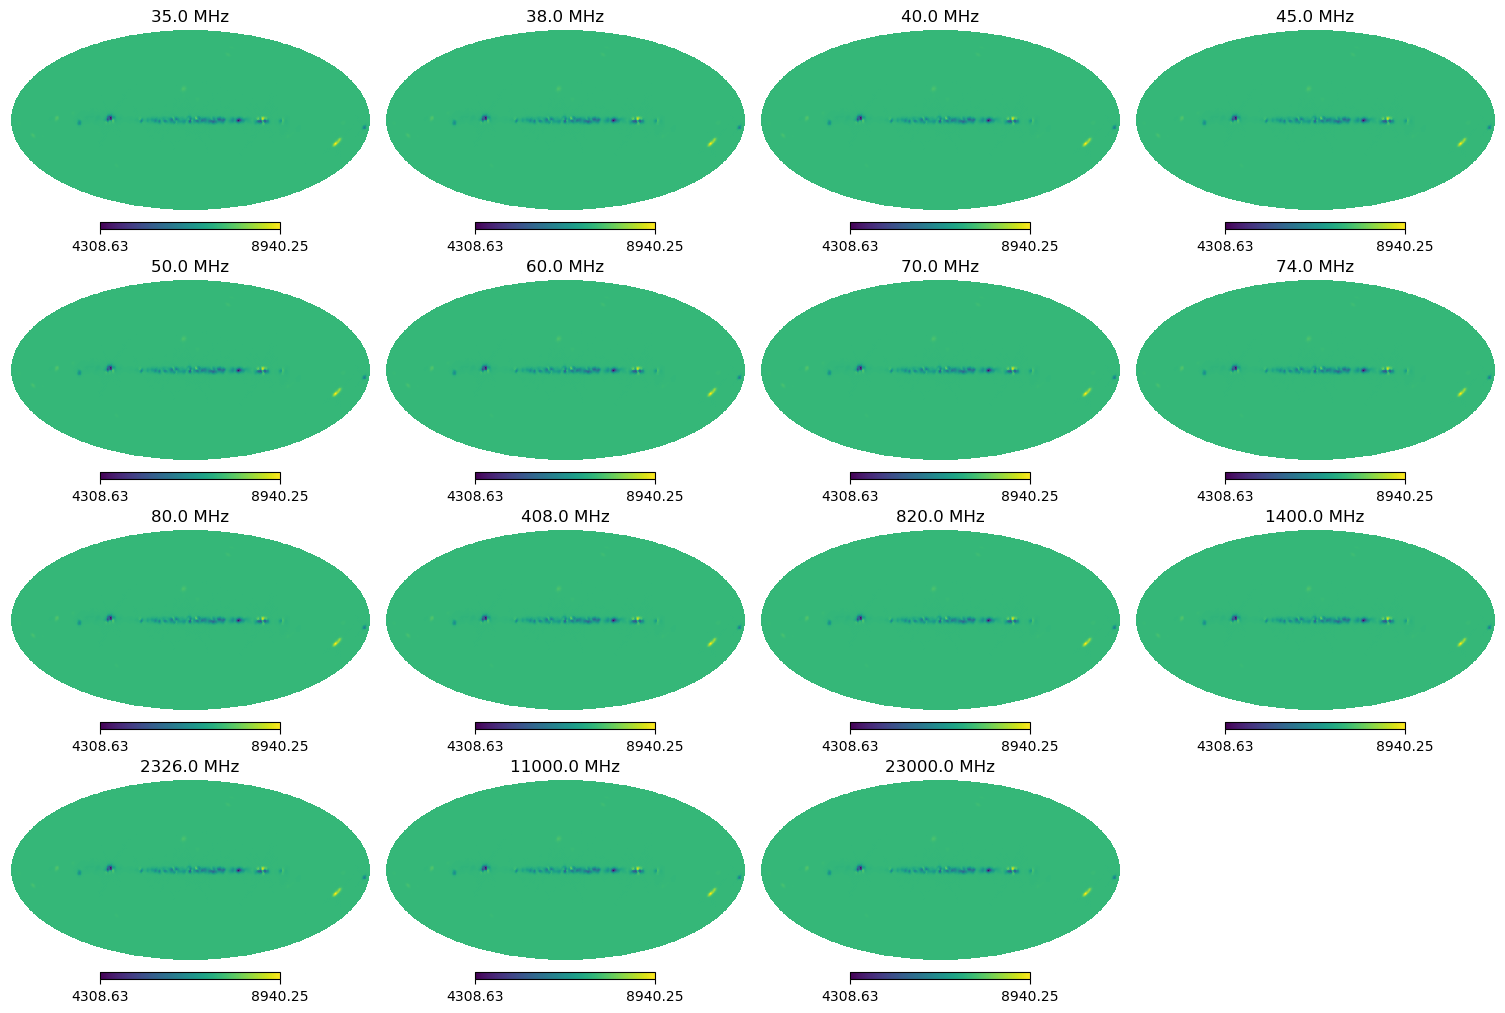

In [10]:
pl.figure(figsize=(15,10)) 
j=0
for fr  in freqs :
     
    hp.mollview(  Tff( planck_te, fr .to(u.GHz ), hust)  ,  title=f'{fr}'  , sub=(4,4,1+j) , notext=True  , norm='log' ) 
    
    j+=1

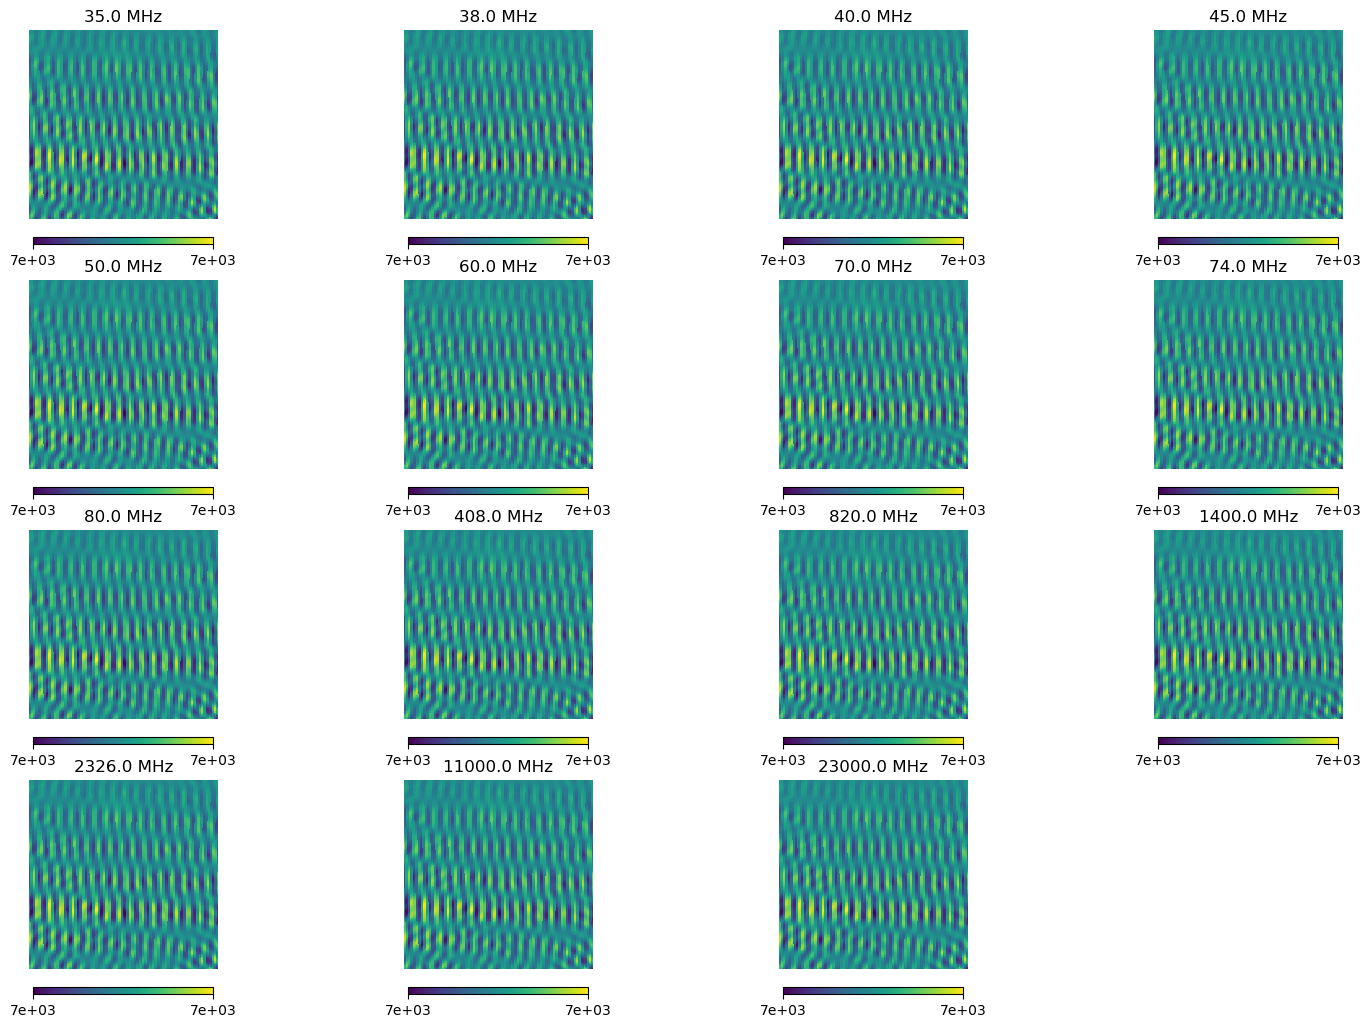

In [59]:
pl.figure(figsize=(15,10)) 
j=0
for fr  in freqs :
     
    hp.gnomview(  Tff( planck_te, fr .to(u.GHz ), hust)  ,  title=f'{fr}'  , sub=(4,4,1+j) , notext=True  , norm='log', reso=3.75, xsize=320 , rot=[0,59]  ) 
    
    j+=1

In [42]:
freqs

<Quantity [   35.,    38.,    40.,    45.,    50.,    60.,    70.,    74.,
              80.,   408.,   820.,  1400.,  2326., 11000., 23000.] MHz>

In [12]:
import  pysm3

sky = pysm3.Sky(nside=256, preset_strings=["f1"]
                     ,   output_unit="K_RJ"  ) 
free ={} 
for fr in freqs  : 
    free[fr] =  pysm3.apply_smoothing_and_coord_transform( sky.get_emission( (fr ).to(u.GHz) ) ,fwhm=1*u.deg )
                                                         #rot=hp.Rotator(coord="GE"))


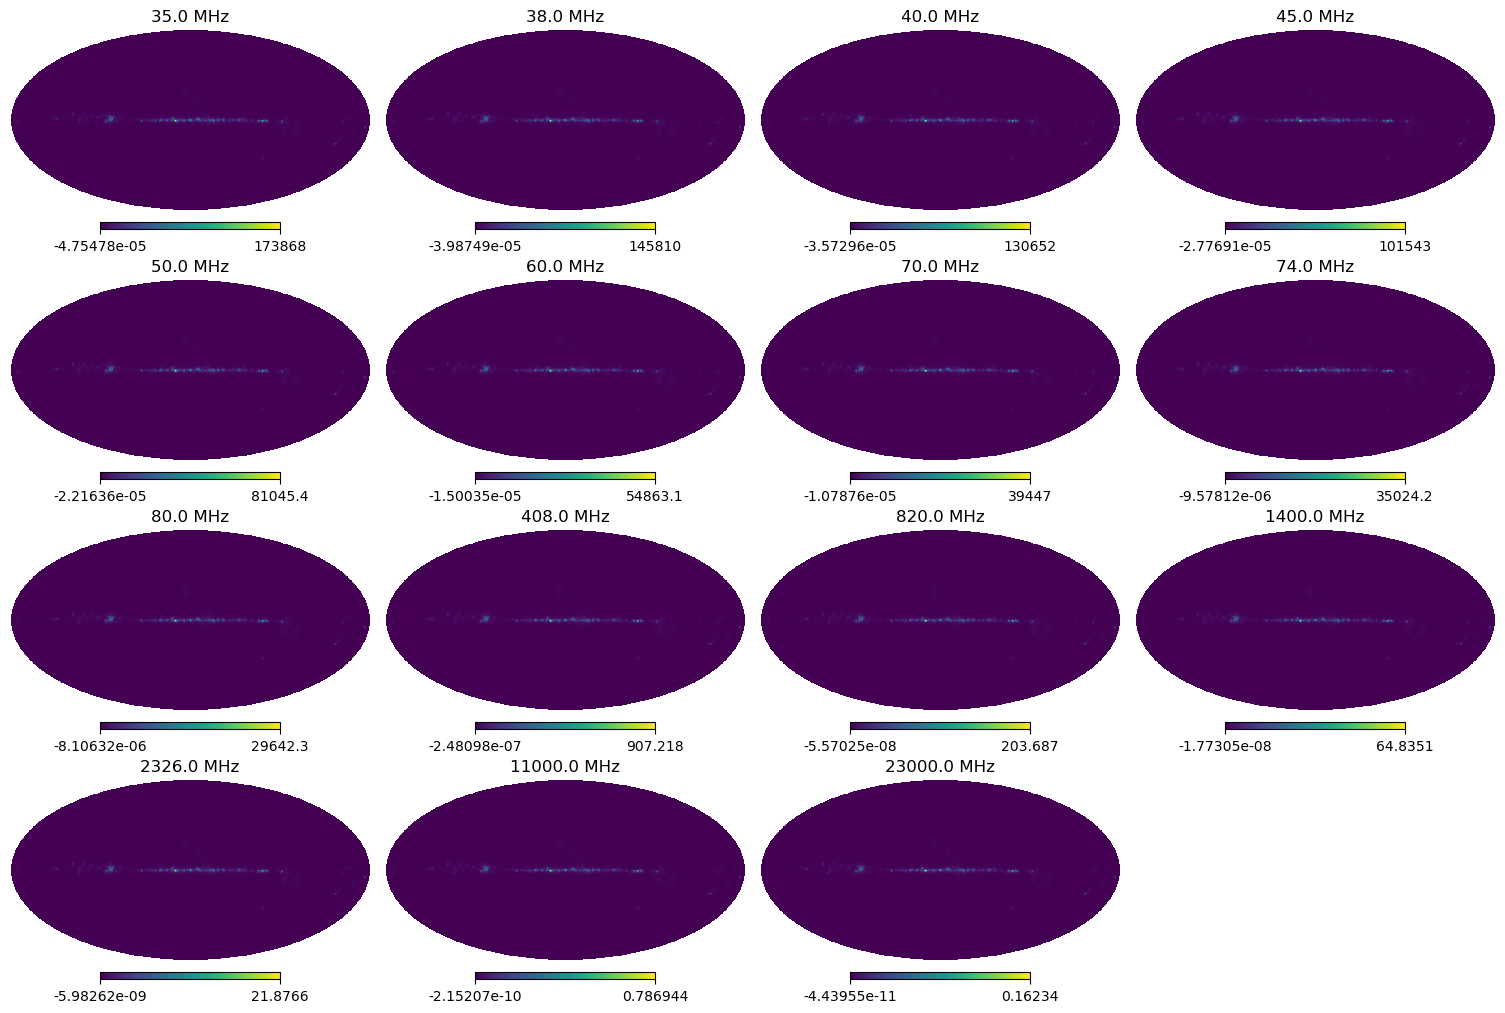

In [15]:
pl.figure(figsize=(15,10)) 
j=0
for fr  in free.keys() :
     
    hp.mollview( free[fr] [0]   ,  title=f'{fr}'  , sub=(4,4,1+j) , notext=True    ) 
    
    j+=1

pl.show() 

In [16]:
pysm = hp.smoothing(sky_map[0] , fwhm=np.radians(1) )

NameError: name 'free' is not defined

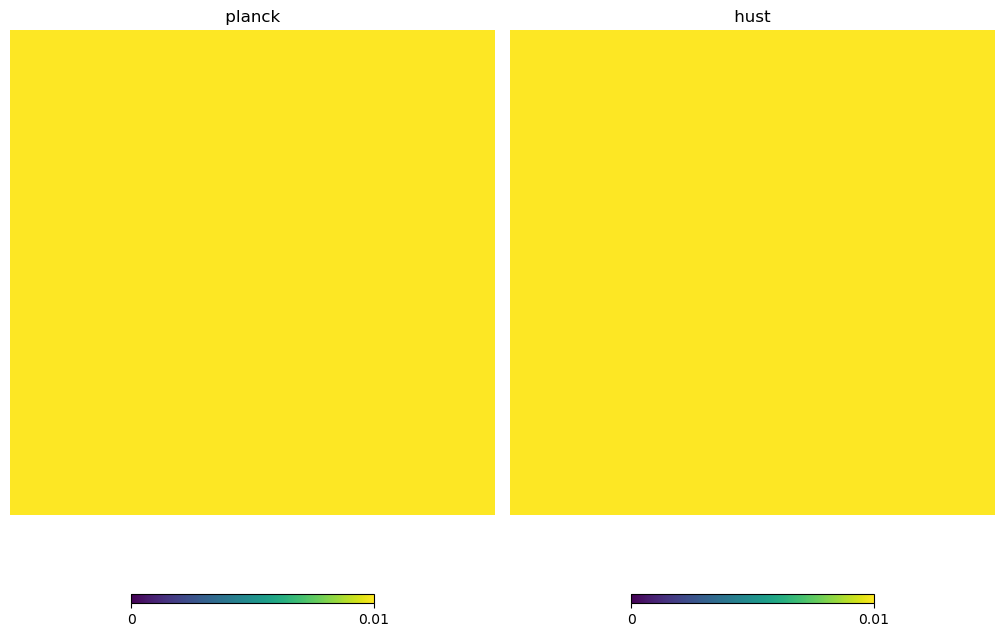

In [11]:

pl.figure(figsize=(15,10)) 
hp.gnomview(  Tff( planck_te,11 * (u.GHz ), hust )  ,  title=f' hust '  , sub=(132) , notext=True  , reso=3.75, xsize=320 , rot=[0,29] , min= 0, max=0.01  ) 
hp.gnomview(  Tff( planck_te, 11* (u.GHz ), planck_em)  ,  title=f' planck '  , sub=(131) , notext=True ,  reso=3.75, xsize=320 , rot=[0,29] , min= 0, max=0.01  ) 
hp.gnomview( free[11000*u.MHz]  [0]   ,  title=f' pysm  '  , sub=(133) , notext=True ,  reso=3.75, xsize=320 , rot=[0,29] , min= 0, max=0.01  ) 


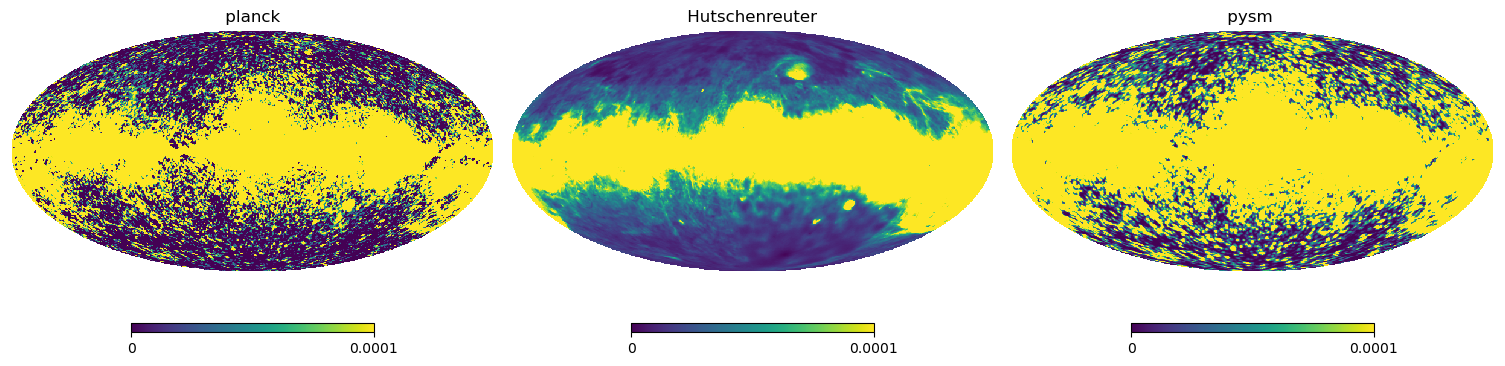

In [53]:

pl.figure(figsize=(15,10)) 
hp.mollview(  Tff( planck_te,11 * (u.GHz ), hust )  ,  title=f' Hutschenreuter '  , sub=(132) , notext=True  ,  min= 0, max=0.0001  ) 
hp.mollview(  Tff( planck_te, 11* (u.GHz ), planck_em)  ,  title=f' planck '  , sub=(131) , notext=True ,   min= 0, max=0.0001  ) 
hp.mollview( free[11000*u.MHz]  [0]   ,  title=f' pysm  '  , sub=(133) , notext=True ,  min= 0, max=0.0001  ) 
